In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


In [2]:
# Función para suavizar las señales
def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Función para cargar datos
def cargar_datos(file_path):
    data = pd.read_csv(file_path, sep='\t', engine='python', decimal=',')
    data.columns = ['Time', 'X', 'Y']
    data = data.dropna()
    data['Time'] /= 1000  # Convertir ms a s
    return data

# Función para calcular velocidad y aceleración
def calcular_vel_acel(data, time):
    vel = np.gradient(data, time)
    acel = np.gradient(vel, time)
    return vel, acel


In [3]:
# Archivos de segmentos
file_paths = {
    'muñeca': r"C:\Users\fabia\Desktop\Trackeos\circular\circular_andy_sagital\muñeca.txt",
    'codo': r"C:\Users\fabia\Desktop\Trackeos\circular\circular_andy_sagital\codo.txt",
    'hombro': r"C:\Users\fabia\Desktop\Trackeos\circular\circular_andy_sagital\hombro.txt",
    'esp_med': r"C:\Users\fabia\Desktop\Trackeos\circular\circular_andy_sagital\medio_torso.txt",
    'cad': r"C:\Users\fabia\Desktop\Trackeos\circular\circular_andy_sagital\cadera.txt",
    'balon': r"C:\Users\fabia\Desktop\Trackeos\circular\circular_andy_sagital\Andy_balon_CIRCULAR.txt"
}



In [4]:

# Cargar datos y suavizar
datos = {label: cargar_datos(path) for label, path in file_paths.items()}
fs = 1 / np.mean(np.diff(datos['muñeca']['Time']))
cutoff = min(20, 0.45 * fs)

In [5]:
for label in datos:
    if len(datos[label]) > 15:  # Verificar que la longitud sea mayor que el padding necesario
        datos[label]['X'] = butter_lowpass_filter(datos[label]['X'], cutoff, fs)
        datos[label]['Y'] = butter_lowpass_filter(datos[label]['Y'], cutoff, fs)
    else:
        print(f"Advertencia: El segmento '{label}' tiene menos de 15 muestras y no se puede suavizar.")

# Calcular aceleraciones por punto
aceleraciones = {}
for label in datos:
    tiempo = datos[label]['Time']
    x = datos[label]['X']
    y = datos[label]['Y']
    _, acel_x = calcular_vel_acel(x, tiempo)
    _, acel_y = calcular_vel_acel(y, tiempo)
    aceleraciones[label] = (acel_x, acel_y, tiempo)

# Factores de Dempster (proporción de la longitud total para el centro de masa)
factores_cm = {
    'antebrazo': 0.43,
    'brazo': 0.436
}

# Calcular distancias entre articulaciones
dist_antebrazo = np.sqrt((datos['muñeca']['X'] - datos['codo']['X'])**2 +
                         (datos['muñeca']['Y'] - datos['codo']['Y'])**2)
dist_brazo = np.sqrt((datos['codo']['X'] - datos['hombro']['X'])**2 +
                     (datos['codo']['Y'] - datos['hombro']['Y'])**2)

# Posiciones del centro de masa
cm_antebrazo = {
    'X': datos['codo']['X'] + factores_cm['antebrazo'] * (datos['muñeca']['X'] - datos['codo']['X']),
    'Y': datos['codo']['Y'] + factores_cm['antebrazo'] * (datos['muñeca']['Y'] - datos['codo']['Y'])
}

cm_brazo = {
    'X': datos['hombro']['X'] + factores_cm['brazo'] * (datos['codo']['X'] - datos['hombro']['X']),
    'Y': datos['hombro']['Y'] + factores_cm['brazo'] * (datos['codo']['Y'] - datos['hombro']['Y'])
}

# Calcular aceleraciones en los centros de masa
acel_cm = {}
acel_cm['antebrazo'] = calcular_vel_acel(cm_antebrazo['X'], datos['muñeca']['Time'])[1], \
                       calcular_vel_acel(cm_antebrazo['Y'], datos['muñeca']['Time'])[1]

acel_cm['brazo'] = calcular_vel_acel(cm_brazo['X'], datos['muñeca']['Time'])[1], \
                   calcular_vel_acel(cm_brazo['Y'], datos['muñeca']['Time'])[1]


In [6]:
# Definir constantes
masa_total_cuerpo = 67  # kg
masa_mano = 0.0061 * masa_total_cuerpo  # Masa de la mano (Dempster)
masa_antebrazo = 0.016 * masa_total_cuerpo  # Masa del antebrazo (16%)
masa_brazo = 0.028 * masa_total_cuerpo  # Masa del brazo (28%)
g = 9.81  # Aceleración gravitatoria en m/s²

# Masa y peso del balón
masa_balon = 0.285  # kg
peso_balon = masa_balon * g  # Peso en Newtons

# Aceleraciones
acel_muneca_x, acel_muneca_y, tiempo = aceleraciones['muñeca']
acel_codo_x, acel_codo_y, _ = aceleraciones['codo']
acel_cm_antebrazo_x, acel_cm_antebrazo_y = acel_cm['antebrazo']
acel_cm_brazo_x, acel_cm_brazo_y = acel_cm['brazo']
acel_balon_x, acel_balon_y, _ = aceleraciones['balon']

# Aceleración en módulos (en m/s², convirtiendo de cm/s²)
modulo_acel_muneca = np.sqrt(acel_muneca_x**2 + acel_muneca_y**2) / 100
modulo_acel_cm_antebrazo = np.sqrt(acel_cm_antebrazo_x**2 + acel_cm_antebrazo_y**2) / 100
modulo_acel_cm_brazo = np.sqrt(acel_cm_brazo_x**2 + acel_cm_brazo_y**2) / 100

# Calcular la fuerza de impacto
modulo_acel_balon = np.sqrt(acel_balon_x**2 + acel_balon_y**2) / 100  # Convertir cm/s² a m/s²
acel_max_balon = np.max(modulo_acel_balon)
fuerza_impacto = masa_balon * acel_max_balon  # Sin peso adicional

# Tiempo de impacto del balón (máxima aceleración en la muñeca)
t_impacto_muneca = tiempo[np.argmax(modulo_acel_muneca)]
idx_impacto_muneca = np.argmax(modulo_acel_muneca)

# Fuerzas
# 1. Fuerza en la muñeca
fuerza_muneca_x = masa_mano * acel_muneca_x / 100
fuerza_muneca_y = masa_mano * acel_muneca_y / 100 - masa_mano * g
fuerza_muneca_resultante = np.sqrt(fuerza_muneca_x**2 + fuerza_muneca_y**2)

# Agregar fuerza de impacto en el instante de golpeo
fuerza_muneca_x[idx_impacto_muneca] += fuerza_impacto
fuerza_muneca_y[idx_impacto_muneca] += fuerza_impacto
fuerza_muneca_resultante[idx_impacto_muneca] = np.sqrt(fuerza_muneca_x[idx_impacto_muneca]**2 +
                                                       fuerza_muneca_y[idx_impacto_muneca]**2)

# 2. Fuerza en el codo (suma de fuerzas de la muñeca y segmento del antebrazo)
fuerza_codo_x = (
    masa_antebrazo * acel_cm_antebrazo_x / 100 +
    fuerza_muneca_x
)
fuerza_codo_y = (
    masa_antebrazo * acel_cm_antebrazo_y / 100 -
    masa_antebrazo * g +
    fuerza_muneca_y
)
fuerza_codo_resultante = np.sqrt(fuerza_codo_x**2 + fuerza_codo_y**2)

# 3. Fuerza en el hombro (suma de fuerzas de codo y segmento del brazo)
fuerza_hombro_x = masa_brazo * acel_cm_brazo_x / 100 + fuerza_codo_x
fuerza_hombro_y = masa_brazo * acel_cm_brazo_y / 100 - masa_brazo * g + fuerza_codo_y
fuerza_hombro_resultante = np.sqrt(fuerza_hombro_x**2 + fuerza_hombro_y**2)

# Recalcular fuerza_muneca si es necesario
try:
    fuerza_muneca = fuerza_muneca_resultante
except NameError:
    print("Advertencia: fuerza_muneca no estaba definida, recalculando...")
    fuerza_muneca = np.sqrt(fuerza_muneca_x**2 + fuerza_muneca_y**2)

# Asegurarse de que las dimensiones de tiempo y fuerzas sean iguales
if len(tiempo) != len(fuerza_muneca):
    raise ValueError("Las dimensiones de 'tiempo' y 'fuerza_muneca' no coinciden. Verifica los cálculos previos.")

# Cálculo de los valores máximos
fuerza_muneca_max = np.max(fuerza_muneca)
fuerza_codo_max = np.max(fuerza_codo_resultante)
fuerza_hombro_max = np.max(fuerza_hombro_resultante)

# Cálculo de las fuerzas en el instante del golpeo
fuerza_codo_impacto = fuerza_codo_resultante[idx_impacto_muneca]
fuerza_hombro_impacto = fuerza_hombro_resultante[idx_impacto_muneca]


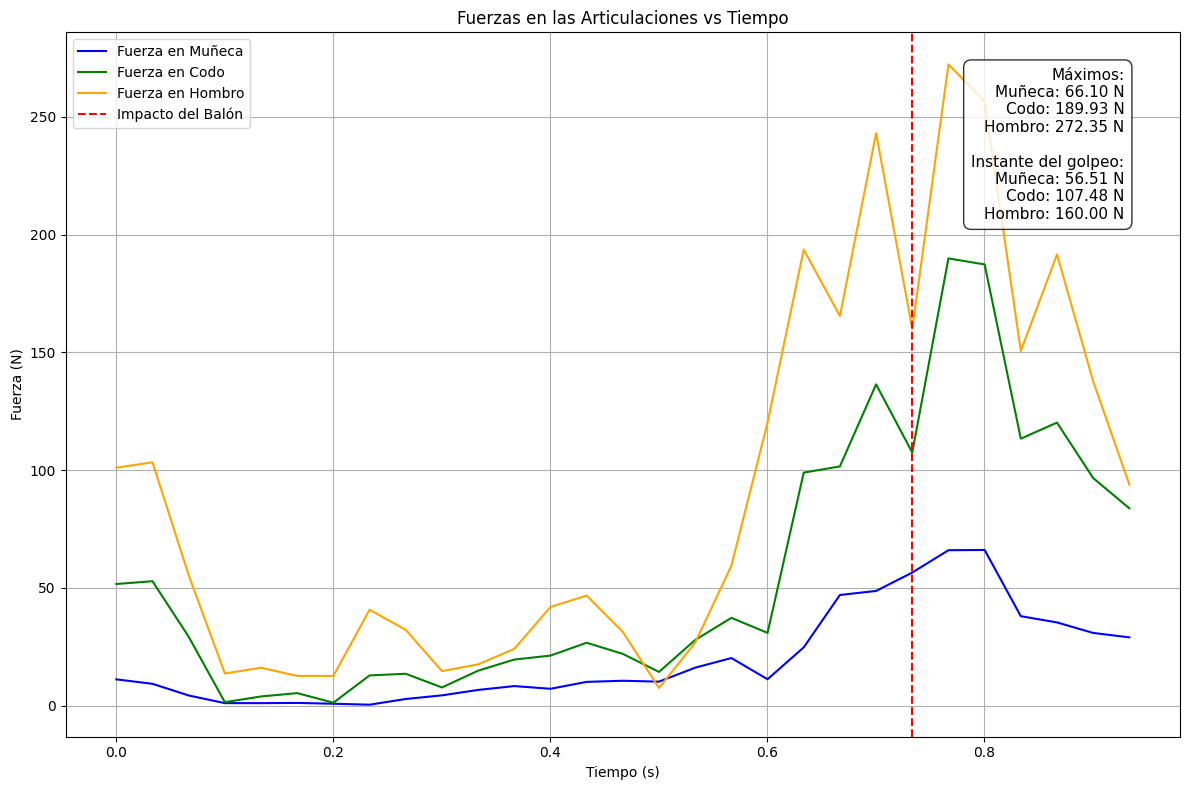

In [7]:
# Graficar fuerzas
plt.figure(figsize=(12, 8))

# Graficar fuerzas con las dimensiones corregidas
plt.plot(tiempo, fuerza_muneca_resultante, label='Fuerza en Muñeca', color='blue')
plt.plot(tiempo, fuerza_codo_resultante, label='Fuerza en Codo', color='green')
plt.plot(tiempo, fuerza_hombro_resultante, label='Fuerza en Hombro', color='orange')

# Línea del impacto
plt.axvline(t_impacto_muneca, color='red', linestyle='--', label='Impacto del Balón')

# Verificación del índice de impacto
if idx_impacto_muneca < len(fuerza_muneca):
    fuerza_muneca_golpeo = fuerza_muneca[idx_impacto_muneca]
else:
    print("Advertencia: El índice del impacto está fuera del rango de 'fuerza_muneca'. Usando el último valor.")
    fuerza_muneca_golpeo = fuerza_muneca[-1]

# Preparar los valores para el cuadro de texto
info_text = (
    f"Máximos:\n"
    f"Muñeca: {fuerza_muneca_max:.2f} N\n"
    f"Codo: {fuerza_codo_max:.2f} N\n"
    f"Hombro: {fuerza_hombro_max:.2f} N\n\n"
    f"Instante del golpeo:\n"
    f"Muñeca: {fuerza_muneca_golpeo:.2f} N\n"
    f"Codo: {fuerza_codo_impacto:.2f} N\n"
    f"Hombro: {fuerza_hombro_impacto:.2f} N"
)

# Mostrar el cuadro de texto en la esquina superior derecha
plt.gca().text(
    0.95, 0.95, info_text,
    transform=plt.gca().transAxes,
    fontsize=11,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(facecolor='white', alpha=0.8, boxstyle="round,pad=0.5")
)

# Configurar el gráfico
plt.xlabel('Tiempo (s)')
plt.ylabel('Fuerza (N)')
plt.title('Fuerzas en las Articulaciones vs Tiempo')
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()